In [3]:
import numpy as np
from netrep.metrics import LinearMetric
from netrep.metrics import GaussianStochasticMetric
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [4]:
networks = {
    "gating": {
        "color": "green",
        "names": [f"data/hdgatingCTRNN_2DIR1O_dr100_n0.1_la0_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "inversion": {
        "color": "red",
        "names": [f"data/hdinversionCTRNN_2DIR1O_dr100_n0.1_la0_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "reshuffle120": {
        "color": "blue",
        "names": [f"data/hdreshuffleCTRNN_2DIR1O_dr100_n0.1_la0_sa120_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "inv+gat": {
        "color": "purple",
        "names": [f"data/hdgatinginversionCTRNN_2DIR1O_dr100_n0.1_la0_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "backpropnd": {
        "color": "black",
        "names": [f"data/backpropndCTRNN_2DIR1O_dr100_n0.1_la0.0001_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "backproprd": {
        "color": "gray",
        "names": [f"data/backproprdCTRNN_2DIR1O_dr100_n0.1_la0.0001_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "notricks": {
        "color": "orange",
        "names": [f"data/hdnotricksCTRNN_2DIR1O_dr100_n0.1_la0_r{i}_dv" for i in range(20)],
        "indices": np.arange(0, 64, 16)
    },
    "diego_phd": {
        "color": "orange",
        "names": ["neuraldata/diego_phd_mst_bothselective"],
        "indices": np.array([0, 1, 2, 3]),
        "neural": True
    }
}
del networks["notricks"]
#del networks["backproprd"]
#del networks["diego_phd"]

In [5]:
for network in networks.values():
    if "neural" in network: continue
    network["errors"] = []
    network["metadatas"] = []
    for name in network["names"]:
        with open(name+"/info.json") as f: info = json.load(f)
        network["errors"].append(info["errors"][2])
        network["metadatas"].append(info)

In [69]:
for name, network in networks.items():
    print(name)
    if 'errors' in network:
        print(network['errors'])

gating
[1.3033890801936239, 1.211681113036735, 1.2989916246803461, 0.9546496594510675, 1.3026467083625788, 1.145959945388154, 1.1794852784496581, 1.2130113624518597, 1.2389827630458117, 1.1652485482469348, 1.151885584897997, 1.2827179106061073, 1.3235803376167736, 1.1790257296678779, 1.23488780125913, 1.1358607878880536, 1.2110119212262325, 1.2108609575260896, 1.1578443721034346, 1.1795331841393704]
inversion
[6.433388591522453, 6.6697119751013645, 6.38939641880825, 6.9772639931129055, 6.432029399595871, 7.3113660666790805, 6.478650464002268, 6.674177071924474, 6.74350454256724, 6.831868208460511, 6.581537734187445, 7.316421109585151, 6.0229777001062, 6.56264909847367, 6.871905653513515, 7.0368616387145275, 6.851401036794751, 6.922276470175185, 8.307116148877268, 6.983184781311562]
reshuffle120
[9.248624132261174, 7.229710832355774, 7.077212512754127, 6.829255383675367, 7.821350699458248, 9.668583866164205, 8.292587408065721, 8.878919998339553, 7.071185956924223, 12.995376938640286, 7.

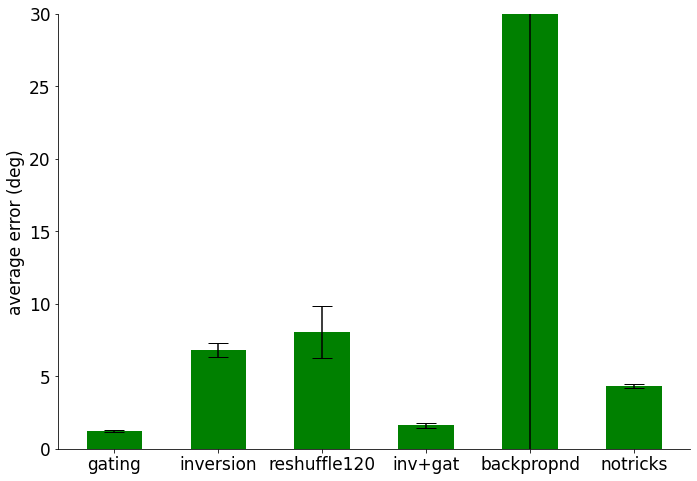

In [144]:
use_networks = list(networks.keys())[:]
means = [np.mean(networks[network]["errors"]) for network in use_networks]
errors = [np.std(networks[network]["errors"]) for network in use_networks]

fig = plt.figure(figsize=(10, 7))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ax = plt.subplot(1, 1, 1)
#ax.yaxis.grid(True)
ax.bar(np.arange(1, len(use_networks)+1)*1.5, means, yerr=errors, align='center', alpha=1, ecolor='black', capsize=10, color="green")
plt.xticks(ticks=np.arange(1, len(use_networks)+1)*1.5, labels=use_networks)
#ax.set_xticklabels(materials)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
#plt.yticks([0, 5, 10, 15, 22, 27], [0, 5, 10, 15, 22+38, 27+38])

plt.ylim(0, 30)
ax.set_ylabel('average error (deg)')
#ax.set_xlabel('')

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [6]:
network = list(networks.values())[1]
j = 3
n_trials = 64
net_size = 100

name = network['names'][j]
array = np.load(name+f"/model_parameterupdate{network['metadatas'][j]['hyperparameters']['train_for_steps']}_fr.npy")
array = array.reshape(n_trials, 280, net_size)

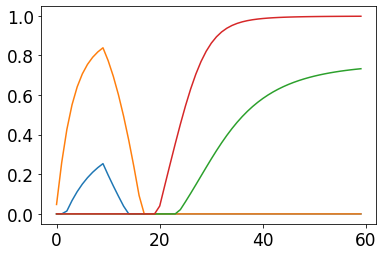

In [194]:
plt.plot(array[0::16, delay0:delay0+s_c_f+delay1, 60].T)

In [7]:
arrays = []
network_names = []
i = 0
for network_name, network in networks.items():
    names = network["names"]
    if "neural" in network:
        for name in names:
            temp = np.load(name+".npy").reshape(4, 2, -1)
            temp = (temp) / (np.expand_dims(np.mean(temp, axis=0), axis=0)+0.05)  #normalization
            temp = temp.reshape(-1, temp.shape[-1])
            arrays.append(temp)
    else:
        for j, name in enumerate(names):
            s_c_f = 10
            delay0, delay1, delay2 = (30, 50, 140)
            t_from = delay0
            t_to = delay0+s_c_f+delay1

            if 'inversion' in network_name and False:
                array = np.load(f"data_old/hdinversionCTRNN_dr100_n0.1_la0_r{j}_dv.npy")
                n_trials = 100
                net_size = 100
                temp = np.zeros((n_trials, 2, net_size))
                temp[:, 0, :] = np.mean(array.reshape(n_trials, 280, net_size)[::, delay0:delay0+s_c_f, :], axis=1)
                temp[:, 1, :] = np.mean(array.reshape(n_trials, 280, net_size)[::, delay0+s_c_f:delay0+s_c_f+delay1, :], axis=1)
                temp = temp[::25]
                temp = (temp) / (np.expand_dims(np.mean(temp, axis=0), axis=0)+0.05)  #normalization
                temp = temp.reshape(-1, net_size)
                arrays.append(temp)
            else:
                model_parameterupdate = network['metadatas'][j]['hyperparameters']['train_for_steps']
                if 'pnd' in network_name: model_parameterupdate=1000
                array = np.load(name+f"/model_parameterupdate{model_parameterupdate}_fr.npy")
                n_trials = 64
                net_size = 100
                temp = np.zeros((n_trials, 2, net_size))
                temp[:, 0, :] = np.mean(array.reshape(n_trials, 280, net_size)[::, delay0:delay0+s_c_f, :], axis=1)
                temp[:, 1, :] = np.mean(array.reshape(n_trials, 280, net_size)[::, delay0+s_c_f:delay0+s_c_f+delay1, :], axis=1)
                temp = temp[network["indices"]]
                temp = (temp) / (np.expand_dims(np.mean(temp, axis=0), axis=0)+0.05)  #normalization
                temp = temp.reshape(-1, net_size)

                #temp = temp + np.random.rand(*temp.shape) * 0.05  # testing adding noise
                arrays.append(temp)
            
    network_names.append(network_name)
    if 'ids' not in network: network['ids'] = []
    for name in names:
        network['ids'].append(i)
        i+=1

In [8]:
N_total = len(arrays)
dist = np.zeros((N_total, N_total))
for i in range(N_total):
    for j in range(N_total):
        X = arrays[i]
        Y = arrays[j]
        metric = LinearMetric(alpha=1.0, zero_pad=True)
        metric.fit(X, Y)
        X = arrays[i]
        Y = arrays[j]
        dist[i, j] = metric.score(X, Y)

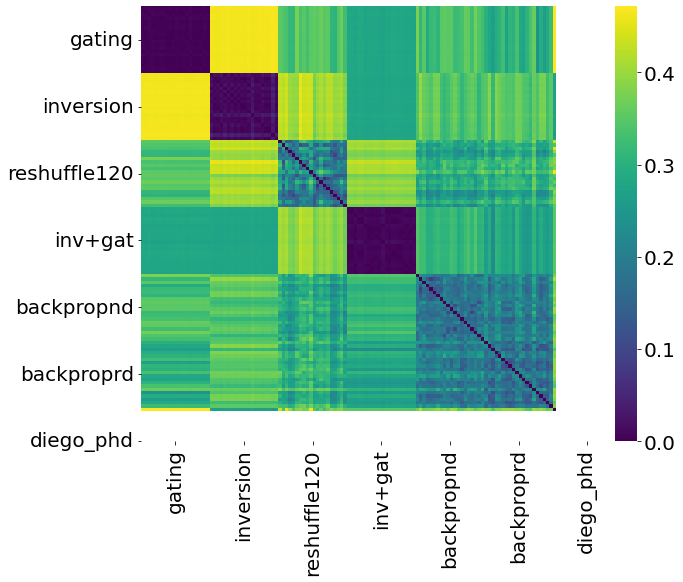

In [9]:
labels_once = list(networks.keys())
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 20})
fig = plt.figure(figsize=(10, 8))
ax = sns.heatmap(dist, cmap="viridis")
plt.xticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once))*20, labels_once, fontsize=20)
plt.yticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once))*20, labels_once, fontsize=20)
#plt.xticks([])
#plt.yticks([])
plt.savefig("distance_matrix.pdf", bbox_inches = 'tight')

/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_3799/3173253143.py:12: RuntimeWarning: Mean of empty slice
  dist_ave[i, j] = np.nanmean(temp)


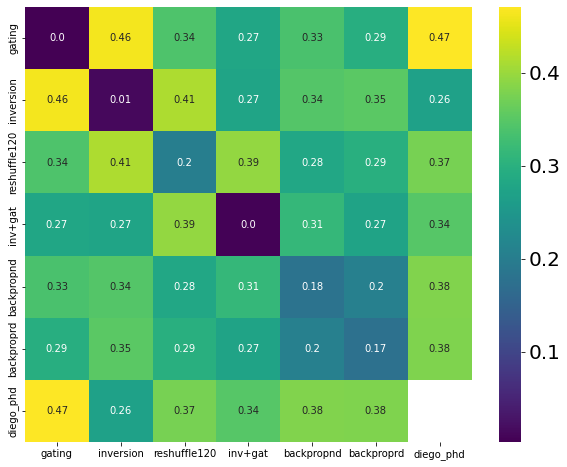

In [10]:
fig = plt.figure(figsize=(10, 8))
n_networks = len(labels_once)
dist_ave = np.zeros((n_networks, n_networks))
for i in range(n_networks):
    for j in range(n_networks):
        temp = np.copy(dist[list(networks.values())[i]['ids'], :][:, list(networks.values())[j]['ids']])
        if i==j: 
            for k in range(len(temp)):
                temp[k, k] = None # remove diagonal elemenrs
        #print(i, j, temp)
        #print(list(networks.values())[i]['ids'], list(networks.values())[j]['ids'])
        dist_ave[i, j] = np.nanmean(temp)
ax = sns.heatmap(dist_ave, cmap="viridis", annot=((dist_ave*100).astype(int)/100).astype(str), annot_kws={'fontsize': 10}, fmt='s')
plt.xticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once)), labels_once, fontsize=10)
plt.yticks(np.linspace(0.5, len(labels_once)-.5, len(labels_once)), labels_once, fontsize=10)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


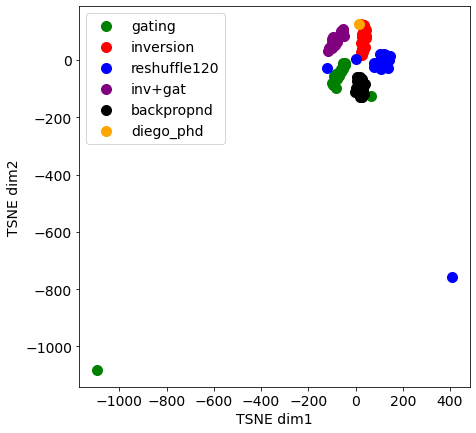

In [51]:
from sklearn.manifold import TSNE
embedded = TSNE(n_components=2, metric='precomputed', perplexity=7).fit_transform(dist)
fig = plt.figure(figsize=(7,7))
for i in range(n_networks):
    plt.scatter(embedded[list(networks.values())[i]['ids'], 0], embedded[list(networks.values())[i]['ids'], 1], 100, list(networks.values())[i]['color'], label=network_names[i])
plt.xlabel("TSNE dim1")
plt.ylabel("TSNE dim2")
plt.legend()

Perplexity value 50 is too high. Using perplexity 40.00 instead
Attempting to use `pca` initalization, but using precomputed distance matrix! Using `spectral` initilization instead, which doesn't need access to the data matrix.


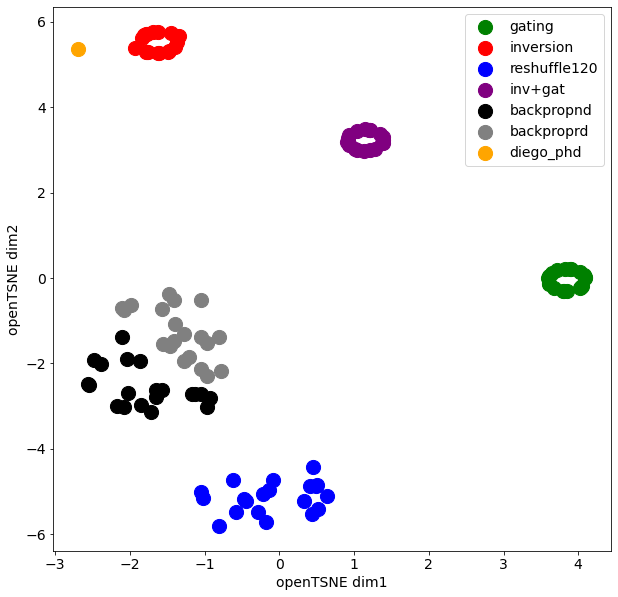

In [12]:
import openTSNE
tsne = openTSNE.TSNE(
    perplexity=50,
    metric='precomputed',
    #n_jobs=3,
    #random_state=1,
    verbose=False
)
dist2 = np.copy(dist)
#dist2 = np.zeros((20, 20))
#dist2[10:, :10] = 0.3
#dist2[:10, 10:] = 0.3
#dist2[dist2<0.03] += 0.1# np.random.rand(*dist2[dist2<0.03].shape)*0.1
embedded = tsne.fit(dist2)
fig = plt.figure(figsize=(10, 10))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
for i in range(n_networks):
    plt.scatter(embedded[list(networks.values())[i]['ids'], 0], embedded[list(networks.values())[i]['ids'], 1], 200, list(networks.values())[i]['color'], label=network_names[i])
plt.xlabel("openTSNE dim1")
plt.ylabel("openTSNE dim2")
plt.legend()
ax = plt.gca()
#ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False);

plt.savefig("ccn_opentsne.pdf", bbox_inches = 'tight')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


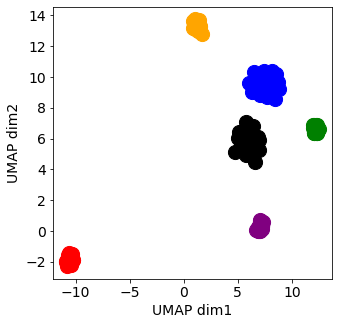

In [174]:
import umap
embedding = umap.UMAP(metric='precomputed', n_neighbors=100, densmap=True).fit_transform(dist)
fig = plt.figure(figsize=(5, 5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
for i in range(n_networks):
    plt.scatter(embedding[list(networks.values())[i]['ids'], 0], embedding[list(networks.values())[i]['ids'], 1], 200, list(networks.values())[i]['color'], label=network_names[i])
plt.xlabel("UMAP dim1")
plt.ylabel("UMAP dim2")
#plt.legend()
plt.show()

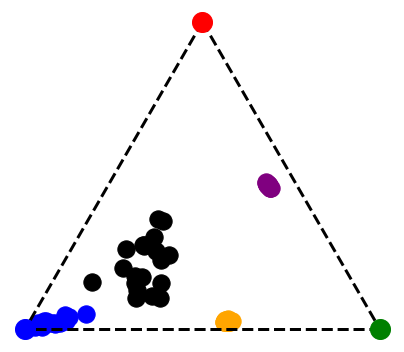

In [194]:
v1 = np.array([0, 1])# (x,y) coordinates of vertex1 for reference model1 in our figure (top vertex of the triangle)
v2 = np.array([np.sqrt(3)/2, -1/2])# (x,y) coordinates of vertex2 for reference model2 in our figure (right vertex the triangle)
v3 = np.array([-np.sqrt(3)/2, -1/2])# (x,y) coordinates of vertex2 for reference model2 in our figure (left vertex of the triangle)
xy = np.zeros((len(dist), 2))
def trans(p):
    r = np.pi/2
    r = .5
    r = np.max(dist)
    d = (r - p)
    #return d**6

    mi, ma = np.min(dist[dist>0.11]), np.max(dist)
    #print(mi)
    d = 1-(p - mi)/(ma-mi)

    d = 1/(p+0.001)**5
    
    return d

for model_id in range(len(dist)):
    temp = np.copy(dist)
    temp[model_id, model_id] = None
    s1 = trans(np.nanmean(dist[list(networks.values())[1]['ids'], model_id]))
    s2 = trans(np.nanmean(dist[list(networks.values())[0]['ids'], model_id]))
    s3 = trans(np.nanmean(dist[list(networks.values())[2]['ids'], model_id]))
    xy[model_id] =  (s1*v1+s2*v2+s3*v3) / (s1+s2+s3)

fig = plt.figure(figsize=(7, 7))
ax = plt.gca()
fontsize = 12
#----------------------
# plot the equilateral triangle
v1v2 = -700*np.ones((2,10))# (x,y) coordinates for one side ofthe equilateral triangle
v1v3 = -700*np.ones((2,10))# (x,y) coordinates for one side ofthe equilateral triangle
v2v3 = -700*np.ones((2,10))# (x,y) coordinates for one side ofthe equilateral triangle
c = np.linspace(0,1,10)
for i in range(10):
    v1v2[:,i] = v1 + c[i]*(v2 - v1)
    v1v3[:,i] = v1 + c[i]*(v3 - v1)
    v2v3[:,i] = v2 + c[i]*(v3 - v2)
ax.plot(v1v2[0,:],v1v2[1,:],'k--',linewidth=3)
ax.plot(v1v3[0,:],v1v3[1,:],'k--',linewidth=3)
ax.plot(v2v3[0,:],v2v3[1,:],'k--',linewidth=3)
#----------------------    
# plot the three reference models
ax.plot(v1[0], v1[1], 'r.', markersize=40)
ax.plot(v2[0], v2[1], 'g.', markersize=40)
ax.plot(v3[0], v3[1], 'b.', markersize=40)
#----------------------
# plot similarities between example models and the three reference models
#ax.plot(xy_example1[0], xy_example1[1], 'g.', markersize=20, label='similarity=0 to all 3 reference models')
#ax.plot(xy_example2[0], xy_example2[1], 'r.', markersize=10, label='similarity=1 to 1 reference model\nsimilarity=0 to the other 2')
#ax.plot(xy_example3[0], xy_example3[1], 'r.', markersize=10)
#ax.plot(xy_example4[0], xy_example4[1], 'r.', markersize=10)
#ax.plot(xy_example5[0,:], xy_example5[1,:], 'b.', markersize=10, label='similarity=0 to reference model1\nsimilarity=rand to the other 2')

for i in range(n_networks):
    color = list(networks.values())[i]["color"]
    if 'neural' in list(networks.values())[i]: size = 700
    else: size = 300
    for index in list(networks.values())[i]["ids"]:
        #if i==3 and j==-1: continue
        ax.scatter(xy[index, 0], xy[index, 1], size, color, label=list(networks.keys())[i], alpha=1)
#ax.scatter(xy[-1, 0], xy[-1, 1], 700, "orange", label="DIEGO_DATA", alpha=1)
#plt.scatter(xy[-1, 0], xy[-1, 1], 100, colors[-1], label=labels[-1])

#----------------------
#ax.legend(bbox_to_anchor=(0.2, 1), loc='best', frameon=True, framealpha=0.9)# fontsize=fontsize
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])
plt.savefig("triangle.pdf")